### 1. Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

### 2. Loading data

In [3]:
df = pd.read_csv("/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip")
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [4]:
print("Dataframe shape : ", df.shape)

Dataframe shape :  (6034195, 4)


In [5]:
df = df.iloc[:10000, :]
print("Shape of Dataframe after subsetting : ", df.shape)

Shape of Dataframe after subsetting :  (10000, 4)


In [6]:
duplicate_pairs = df.sort_values(by = "Title", ascending = False).duplicated("Title")
print("Total number of duplicate questions: {}".format(duplicate_pairs.sum()))
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal: {}".format(df.shape))

Total number of duplicate questions: 4
Dataframe shape after duplicate removal: (9996, 4)


In [7]:
df["Tags"] = df["Tags"].astype(str)

In [8]:
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

**Frequency of tag count**

In [9]:
df["tag_count"].value_counts()

3    2919
2    2612
4    1969
1    1296
5    1200
Name: tag_count, dtype: int64

In [10]:
print("Maximum number of tags in a question: {}".format(df["tag_count"].max()))
print("Minmum number of tags in a question: {}".format(df["tag_count"].min()))
print("Average number of tags in a question: {}".format(df["tag_count"].mean()))

Maximum number of tags in a question: 5
Minmum number of tags in a question: 1
Average number of tags in a question: 2.916466586634654


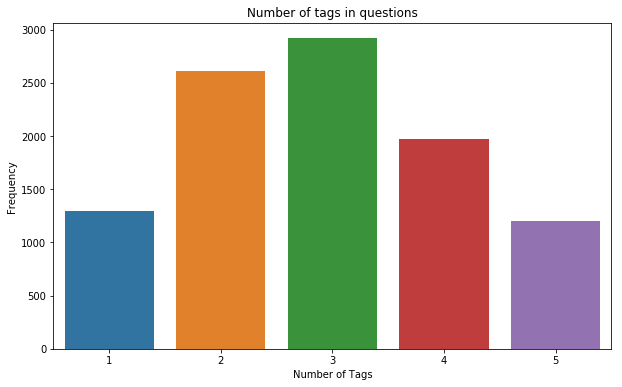

In [11]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = "tag_count")
plt.title("Number of tags in questions")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.show()

Observations:

* Maxmum number of tags in a questions: 5
* Minimum number of tags in a question: 1
* Average number of tags per question: 2.92
* Most of the questions have either 2 or 3 tags

**Total number of unique tags**

In [12]:
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df["Tags"])

In [13]:
print("Number of questions: {}".format(bag_of_words.shape[0]))
print("Number of unique tags: {}".format(bag_of_words.shape[1]))

Number of questions: 9996
Number of unique tags: 4917


**Frequency of each tag**

In [14]:
tags = vectorizer.get_feature_names()

In [15]:
freq = bag_of_words.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags, freq))

In [16]:
list = []
for key, value in tag_to_count_map.items():
    list.append([key, value])

In [17]:
tag_df = pd.DataFrame(list, columns = ["Tags", "Count"])

In [18]:
tag_df.sort_values(by = "Count", ascending = False).head(10)

,Tags,Count
2708,net,960
2077,java,753
3108,php,725
166,android,699
2146,jquery,654
2084,javascript,651
251,asp,544
3981,sql,534
4756,windows,477
3648,ruby,442


**Distribution of frequency of tags based on appeareance**

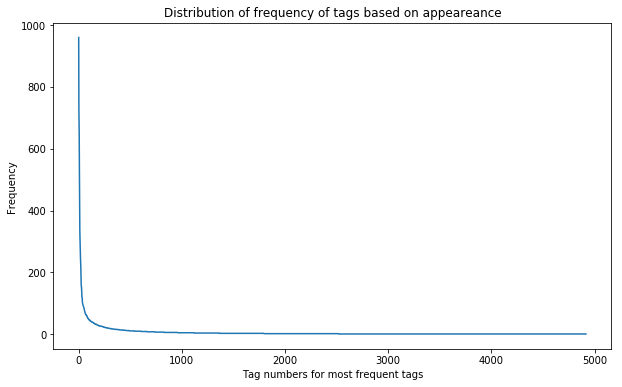

In [19]:
tag_df_sorted = tag_df.sort_values(by = "Count", ascending = False)

plt.figure(figsize = (10, 6))
plt.plot(tag_df_sorted["Count"].values)
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

**Top 100 tags : Distribution of frequency of tags based on appeareance**

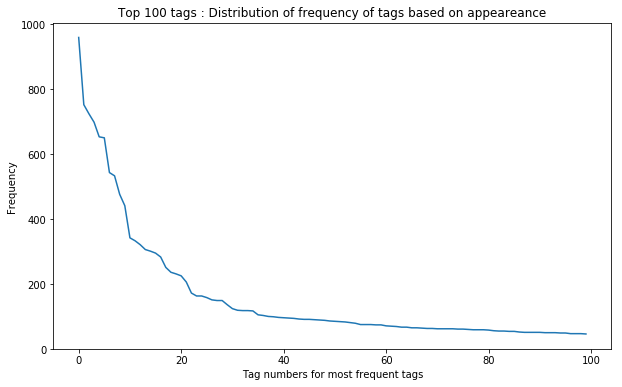

In [20]:
plt.figure(figsize = (10, 6))

plt.plot(tag_df_sorted['Count'][0:100].values)
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

**Top 20 most frequent Tags**

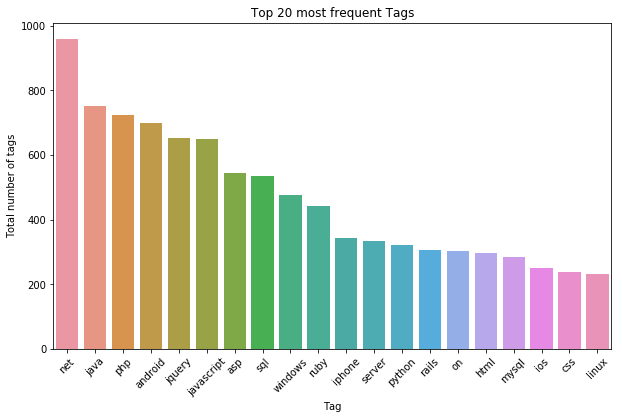

In [21]:
plt.figure(figsize = (10, 6))
top_20_most_tags = tag_df.sort_values(by = "Count", ascending = False).head(20)
sns.barplot(x = top_20_most_tags["Tags"],
            y = top_20_most_tags["Count"])
plt.title("Top 20 most frequent Tags")
plt.xlabel("Tag")
plt.ylabel("Total number of tags")
plt.xticks(rotation = 45)
plt.show()

**Word map for most frequent Tags**

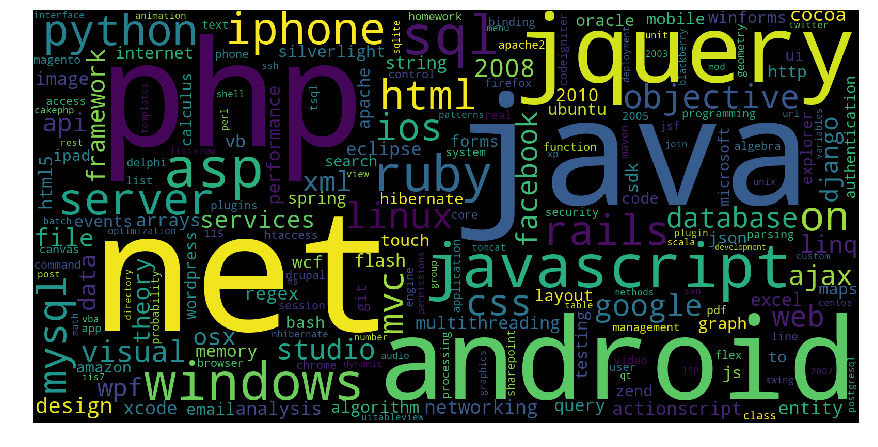

In [22]:
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

**Text preprocessing: We combine 2 columns "Title" and "Body" into a single one, namely "question"**

In [23]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [24]:
ques_list = []
ques_with_code = 0
len_before_preprocessing = 0
len_after_preprocessing = 0

for index, row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if "<code>" in body:
        ques_with_code += 1
    len_before_preprocessing += len(title) + len(body)
    body = re.sub("<code>(.*?)</code>", "", body)
    body = re.sub("<.*?>", "", str(body.encode("utf-8")))
    
    title = title.encode("utf-8")
    
    question = str(title) + " " + str(body)
#     print(question)
    question = re.sub(r"[^A-Za-z]+", " ", question)
    
    words = word_tokenize(str(question.lower()))
    question = " ".join(str(lemmatizer.lemmatize(word)) for word in words if
                           word not in stop_words and len(word) > 1)
#     print()
#     print(question)
    ques_list.append(question)
    len_after_preprocessing += len(question)

df["question"] = ques_list
avg_len_before_preprocessing = (len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing = (len_after_preprocessing*1.0)/df.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (ques_with_code*100.0)/df.shape[0])

Avg. length of questions(Title+Body) before preprocessing:  1158.4714885954381
Avg. length of questions(Title+Body) after preprocessing:  679.3864545818327
% of questions containing code:  55.88235294117647


In [25]:
preprocessed_df = df[["question", "Tags"]]
print("Shape if preprocessed data:", preprocessed_df.shape)

Shape if preprocessed data: (9996, 2)


**Machine Learning models**

In [26]:
preprocessed_df.head()

,question,Tags
0,check uploaded file image without mime type li...,php image-processing file-upload upload mime-t...
1,prevent firefox closing press ctrl favorite ed...,firefox
2,error invalid type list variable import matlab...,r matlab machine-learning
3,replace special character url probably simple ...,c# url encoding
4,modify whois contact detail function modify mc...,php api file-get-contents


In [27]:
# vectorizer = CountVectorizer()
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df["Tags"])

In [28]:
y_multilabel

<9996x6124 sparse matrix of type '<class 'numpy.int64'>'
	with 29153 stored elements in Compressed Sparse Row format>

In [29]:
def tags_to_consider(n):
    tags_i_sum = y_multilabel.sum(axis = 0).tolist()[0]
    sorted_tags_index = sorted(range(len(tags_i_sum)), key = lambda i: tags_i_sum[i],
                              reverse = True) # 6124
    yn_multilabel = y_multilabel[:, sorted_tags_index[:n]]
    return yn_multilabel

def questions_covered_func(n):
    yn_multilabel = tags_to_consider(n)
    x = yn_multilabel.sum(axis = 1) # 9996
    return (np.count_nonzero(x == 0))

In [30]:
questions_covered = []
total_questions = y_multilabel.shape[0] # 9996
total_tags = y_multilabel.shape[1] # 6124
for i in range(100, total_tags, 100):
    questions_covered.append(
        np.round(
            ((total_questions - questions_covered_func(i)) / total_questions) * 100, 3
        )
    )

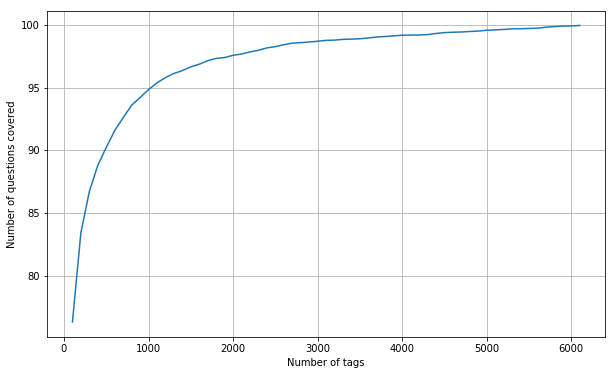

94.848 % questions covered by 1000 tags


In [31]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(100, total_tags, 100), questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered")
plt.grid()
plt.show()
print(questions_covered[9], "% questions covered by 1000 tags")

**Quan sát: Chúng ta có tổng cộng hơn 6000 tags, nhưng số lượng những tags có số lần xuất hiện nhiều lại rất ít, số lượng những tags có số lần xuất hiện ít lại rất nhiều (hơn 95% số câu hỏi được đề cập đến chỉ với 1000 tags xuất hiện nhiều nhất)**

In [32]:
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [33]:
yx_multilabel = tags_to_consider(1000)
yx_multilabel.shape

(9996, 1000)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df,
    yx_multilabel,
    test_size = 0.2,
    random_state = 42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7996, 2) (7996, 1000)
(2000, 2) (2000, 1000)


In [35]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train["question"])
X_test_multilabel = vectorizer.transform(X_test["question"])

In [36]:
print(X_train_multilabel.shape, y_train.shape)
print(X_test_multilabel.shape, y_test.shape)

(7996, 200000) (7996, 1000)
(2000, 200000) (2000, 1000)


**Test (Linear Support Vector Machine)**

In [37]:
# clf = OneVsRestClassifier(SGDClassifier(loss='hinge', 
#                                         alpha=0.00001, 
#                                         penalty='l2', 
#                                         max_iter = 10000, 
#                                         random_state = 42))
clf = OneVsRestClassifier(SGDClassifier(loss = "hinge",
                                        max_iter = 10000,
                                        random_state = 42))
clf.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=10000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=42, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [38]:
y_pred = clf.predict(X_test_multilabel)

In [39]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.1135
Macro f1 score : 0.04455963153601686
Micro f1 score : 0.2775246772968869
Hamming loss : 0.001903


**Hyperparameters tuning (chưa chạy)**

In [40]:
params_grid = {
    "estimator__alpha": [1e-7, 1e-6],
    "estimator__penalty": ["l2", "elasticnet"],
    "estimator__l1_ratio": [0.1, 0.5, 0.9]
}

grid_search = GridSearchCV(
    clf,
    params_grid,
    scoring = "accuracy",
    cv = 3,
    refit = True
)

In [ ]:
grid_search.fit(X_train_multilabel, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(X_test_multilabel)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

**20 Tags Testing**

In [ ]:
df.shape

In [ ]:
df_tags = df.iloc[:30000, :]
print("Shape of Dataframe after subsetting : ", df_tags.shape)

In [ ]:
duplicate_pairs = df_tags.sort_values(by = "Title", ascending = False).duplicated("Title")
print("Total number of duplicate questions: {}".format(duplicate_pairs.sum()))
df_tags = df_tags[~duplicate_pairs]
print("Dataframe shape after duplicate removal: {}".format(df_tags.shape))

In [ ]:
df_tags["Tags"] = df_tags["Tags"].astype(str)

In [ ]:
ques_list = []
ques_with_code = 0
len_before_preprocessing = 0
len_after_preprocessing = 0

for index, row in df_tags.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if "<code>" in body:
        ques_with_code += 1
    len_before_preprocessing += len(title) + len(body)
    body = re.sub("<code>(.*?)</code>", "", body)
    body = re.sub("<.*?>", "", str(body.encode("utf-8")))
    
    title = title.encode("utf-8")
    
    question = str(title) + " " + str(body)
#     print(question)
    question = re.sub(r"[^A-Za-z]+", " ", question)
    
    words = word_tokenize(str(question.lower()))
    question = " ".join(str(lemmatizer.lemmatize(word)) for word in words if
                           word not in stop_words and len(word) > 1)
#     print()
#     print(question)
    ques_list.append(question)
    len_after_preprocessing += len(question)

df_tags["question"] = ques_list
avg_len_before_preprocessing = (len_before_preprocessing*1.0)/df_tags.shape[0]
avg_len_after_preprocessing = (len_after_preprocessing*1.0)/df_tags.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (ques_with_code*100.0)/df_tags.shape[0])

In [ ]:
df_tags

In [ ]:
list_tags = ['java','html','asp.net','c#',
             'ruby-on-rails','jquery','mysql','php','ios','javascript',
             'python','c','css','android',
             'iphone','sql','objective-c','c++','angularjs','.net']

df_tags = df_tags[(df_tags['Tags'].isin(list_tags))][['question', 'Tags']]

df_tags.head()

In [ ]:
df_tags.shape

In [ ]:
X = df_tags["question"]
y = df_tags["Tags"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42
)

X_train.shape, X_test.shape

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sgd", SGDClassifier(random_state = 42, 
                          max_iter = 10000))
])
pipe.fit(X_train, y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print("Accuracy with default settings: {}".format(metrics.accuracy_score(y_test, y_pred)))

**Hyperparameters tuning**

In [ ]:
params_grid = {
    "sgd__alpha": [1e-5, 1e-4, 1e-3],
    "sgd__penalty": ["l1", "l2", "elasticnet", "none"],
    "sgd__l1_ratio": [0.05, 0.1, 0.25, 0.5, 0.7, 0.75, 0.9]
}

search = GridSearchCV(
    pipe,
    params_grid,
    scoring = "accuracy",
    cv = 5,
    refit = True
)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
search.best_params_

**Analysis results**

In [ ]:
results = pd.DataFrame(search.cv_results_)
print(results.shape)

results.sort_values(by = "mean_test_score", ascending = False, inplace = True)
results.reset_index(drop = True, inplace = True)
results[[
    "param_sgd__alpha", "param_sgd__penalty", "param_sgd__l1_ratio",
    "mean_test_score", "std_test_score"
]].head()

**In total, we have 45 Hyperparameter Combinations!**

**Model performance base on the combinations of hyperparameters**

In [ ]:
# plot model performance and error
plt.figure(figsize = (10, 6))
results["mean_test_score"].plot(yerr = [results["std_test_score"], results["std_test_score"]], subplots = True)
plt.title("Mean test score and Std of Hyperparameters Combinations")
plt.ylabel("Mean test score")
plt.xlabel("Hyperparameter Combinations")
plt.show()

**Model performance base on single hyperparameter**

In [ ]:
def summarize_by_param(hparam):
    tmp = pd.concat([
        results.groupby(hparam)["mean_test_score"].mean(),
        results.groupby(hparam)["mean_test_score"].std()
    ], axis = 1)
    tmp.columns = ["mean_test_score", "std_test_score"]
    
    return tmp

In [ ]:
tmp = summarize_by_param("param_sgd__alpha")
tmp

In [ ]:
plt.figure(figsize = (10, 6))
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.title("Mean test score and Std of different alpha values")
plt.ylabel("Mean test score")
plt.xlabel("alpha")
plt.show()

**The optimal "alpha" parameter seems to be somewhere between 1e-4 and 1e-3**

In [ ]:
tmp = summarize_by_param("param_sgd__penalty")
tmp

In [ ]:
plt.figure(figsize = (10, 6))
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.title("Mean test score and Std of different penalty term")
plt.ylabel("Mean test score")
plt.xlabel("penalty")
plt.show()

In [ ]:
tmp = summarize_by_param("param_sgd__l1_ratio")
tmp

In [ ]:
plt.figure(figsize = (10, 6))
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.title("Mean test score and Std of different l1_ratio values")
plt.ylabel("Mean test score")
plt.xlabel("l1_ratio")
plt.show()

**The optimal "l1_ratio" parameter seems to be somewhere between 0.1 and 0.5**

In [ ]:
y_preds = search.predict(X_test)
print(metrics.accuracy_score(y_test, y_preds))

**Determine hyperparameter space and using RandomSearchCV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sgd", SGDClassifier(random_state = 42, 
                          max_iter = 10000, 
                          penalty = "elasticnet"))
])

In [ ]:
params_grid = {
    "sgd__alpha": stats.uniform(1e-4, 1e-3),
    "sgd__penalty": ["elasticnet"],
    "sgd__l1_ratio": stats.uniform(0.1, 0.5)
}

In [ ]:
search = RandomizedSearchCV(
    pipe,
    params_grid,
    scoring = "accuracy",
    cv = 5,
    n_iter = 100,
    random_state = 42,
    refit = True
)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
search.best_params_

In [ ]:
y_preds = search.predict(X_test)
print(metrics.accuracy_score(y_test, y_preds))